# FYSC12: Beta decay and Fermi Kurie plot
## Data analysis code and lab notebook

### Introduction
* Intro text here

### Let's take some data!
#### describe your experiment and settings here

**Important**: write down any settings you apply!

Some initialization in our program:

In [1]:
## set up some print-out routines (logging)
import logging
#FORMAT = '%(asctime)s %(name)s:line %(lineno)-4d %(levelname)-8s %(message)s'
#logging.basicConfig(format=FORMAT)
log = logging.getLogger('betalab_analysis') ## set up logging
log.setLevel("INFO")
log.info("test!!!")

INFO:betalab_analysis:test!!!


#### Load the data from the MCA
We have a little helper library called MCA.py that we load here. It provides a new class *Spectrum* and a routine to load (ASCII) files from the MCA: *load_spectrum("filename")*

In [4]:
import MCA
sr90 = MCA.load_spectrum('data/sr90.Spe')
cs137 = MCA.load_spectrum('data/cs137.Spe')

To plot things, we use the *matplotlib* library. We need to import it before the first use and initialize the interactive use inside the notebook:

In [6]:
import matplotlib
# choose a backend for web applications; remove for stand-alone applications:
matplotlib.use('Agg')
import matplotlib.pyplot as plt
# enable interactive notebook plots (
# alternative: use 'inline' instead of 'notebook' for static images)
%matplotlib notebook

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Now it's time to plot the data we just measured!
Run the cell below to see the result appear inside the notebook:

<IPython.core.display.Javascript object>


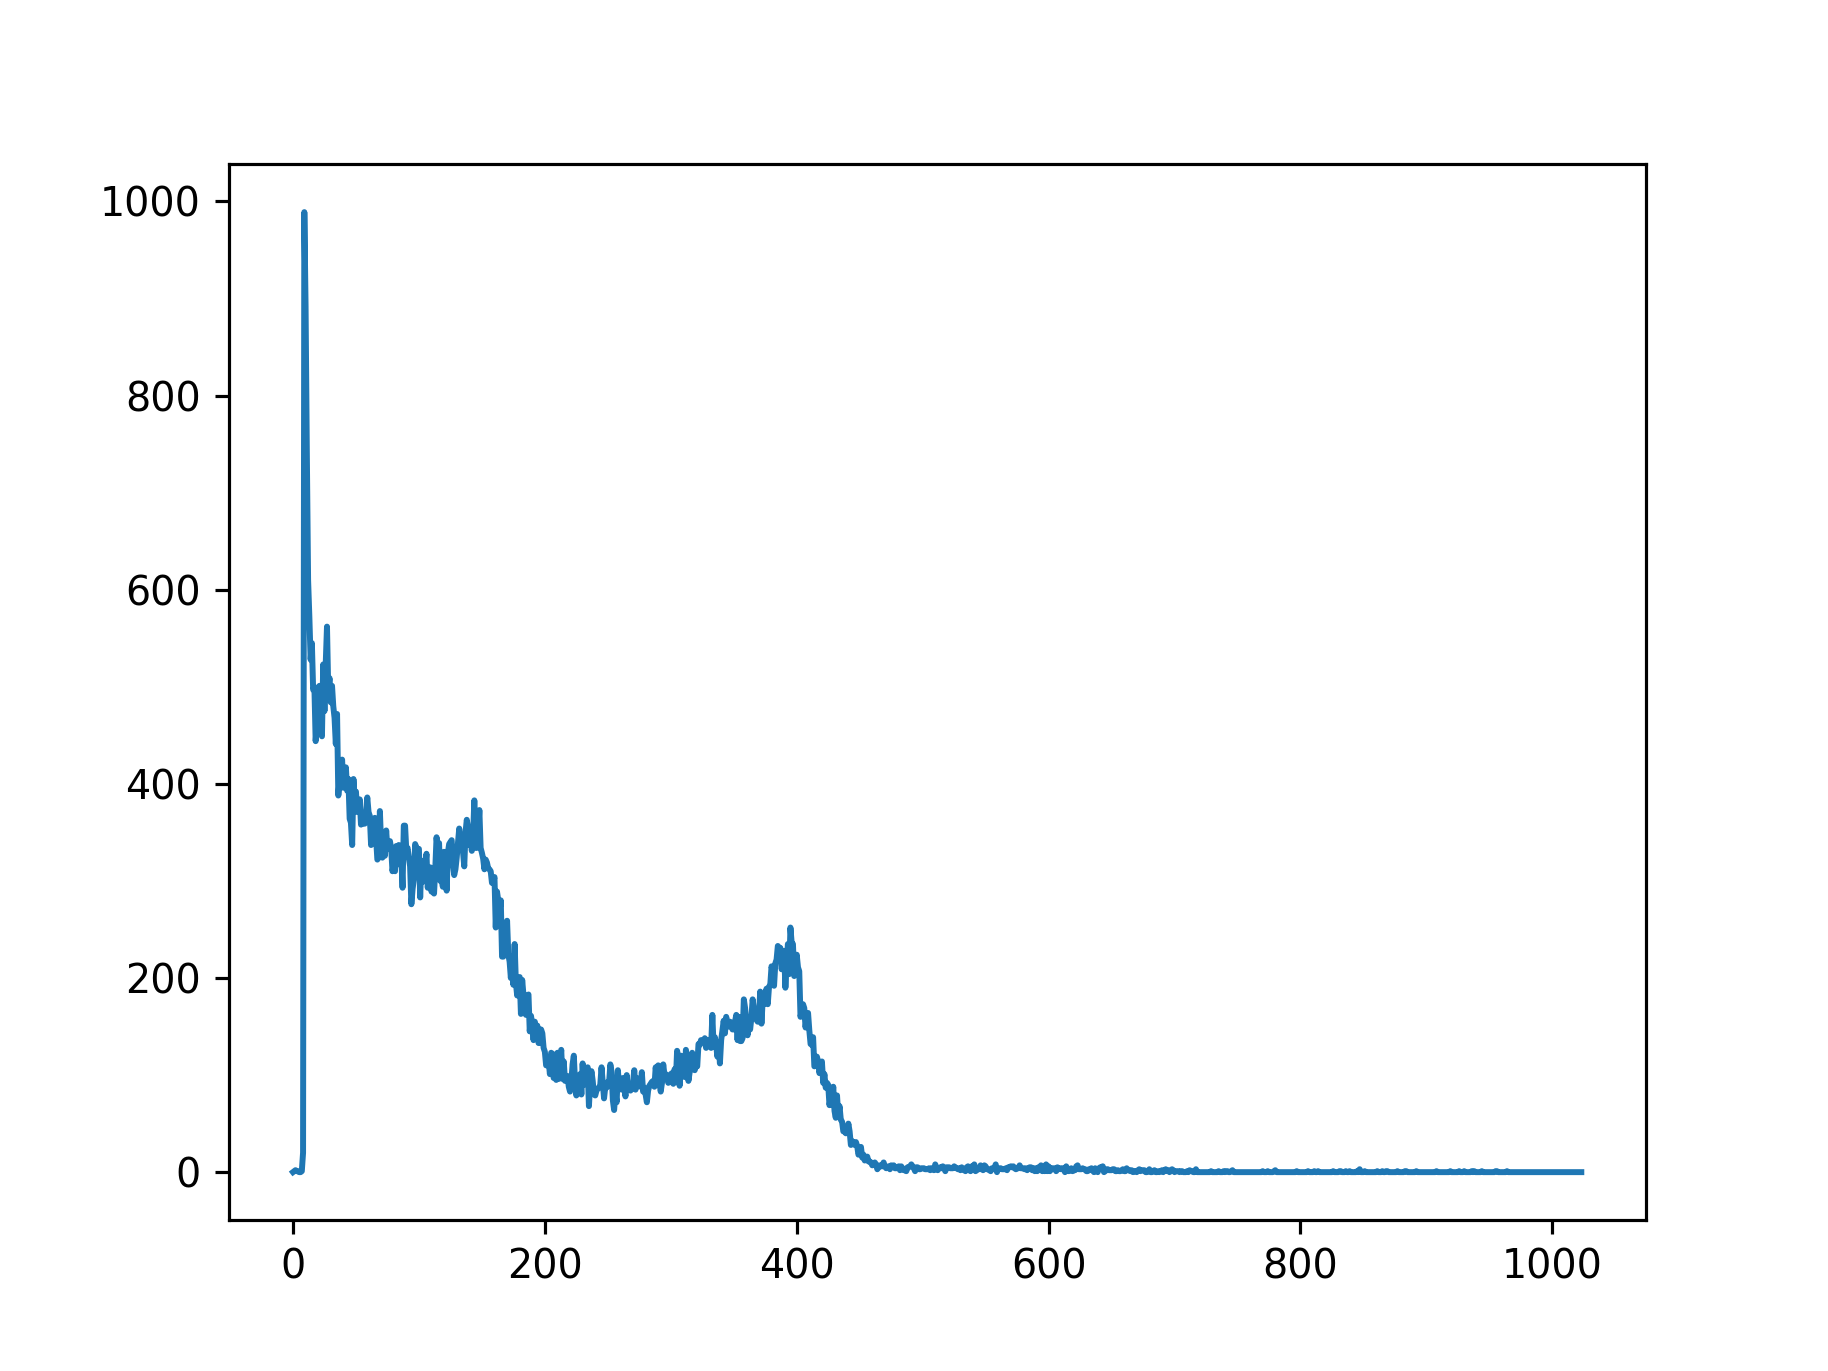

In [5]:
fig, axes = plt.subplots() # makes new plot
axes.plot(cs137.x, cs137.y, linestyle="steps")

The result looks (hopefully) more-or-less identical to what we have seen in the MCA software. Good, let's proceed with the analysis then!

**Note**: if you use a pure Python program (not a notebook like we do today) and want to plot with matplotlib, then you need to adjust the indicated lines around the matplotlib import statement add the *plt.show()* command (without arguments) to actually _show_ the plots in a separate window.

In [8]:
import fithelpers
gfits = fithelpers.fit_all_gaussians(cs137.x, cs137.y)

<IPython.core.display.Javascript object>


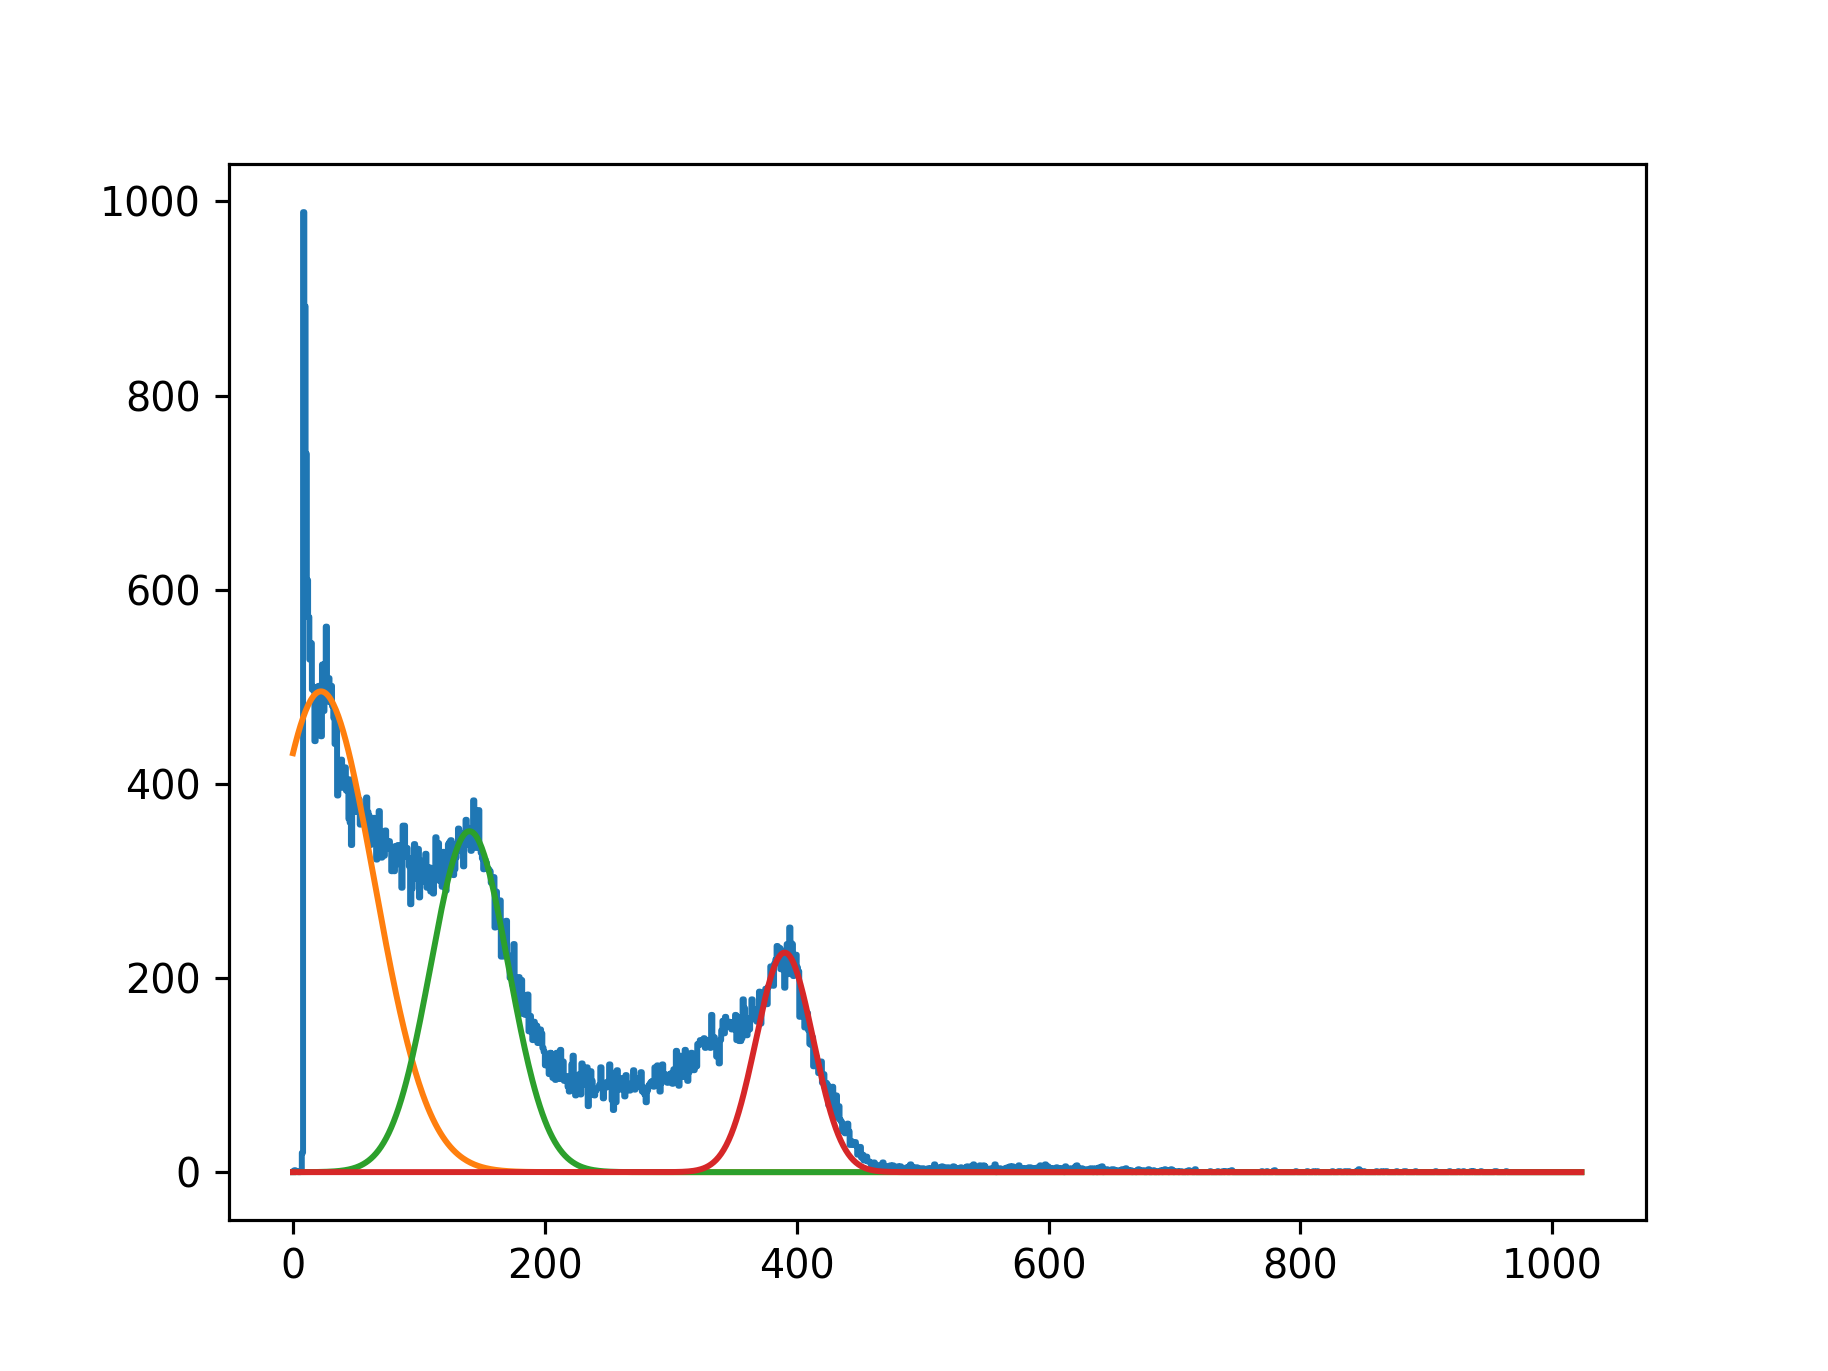

In [9]:
fig, axes = plt.subplots() # makes new plot

axes.plot(cs137.x, cs137.y, label = 'data', linestyle="steps")
for g in gfits:
    ## plot the gaussian fit
    axes.plot(cs137.x, g.value(cs137.x), 
              label = "Gaussian fit, sgm="+str(round(g.sigma)))


<IPython.core.display.Javascript object>


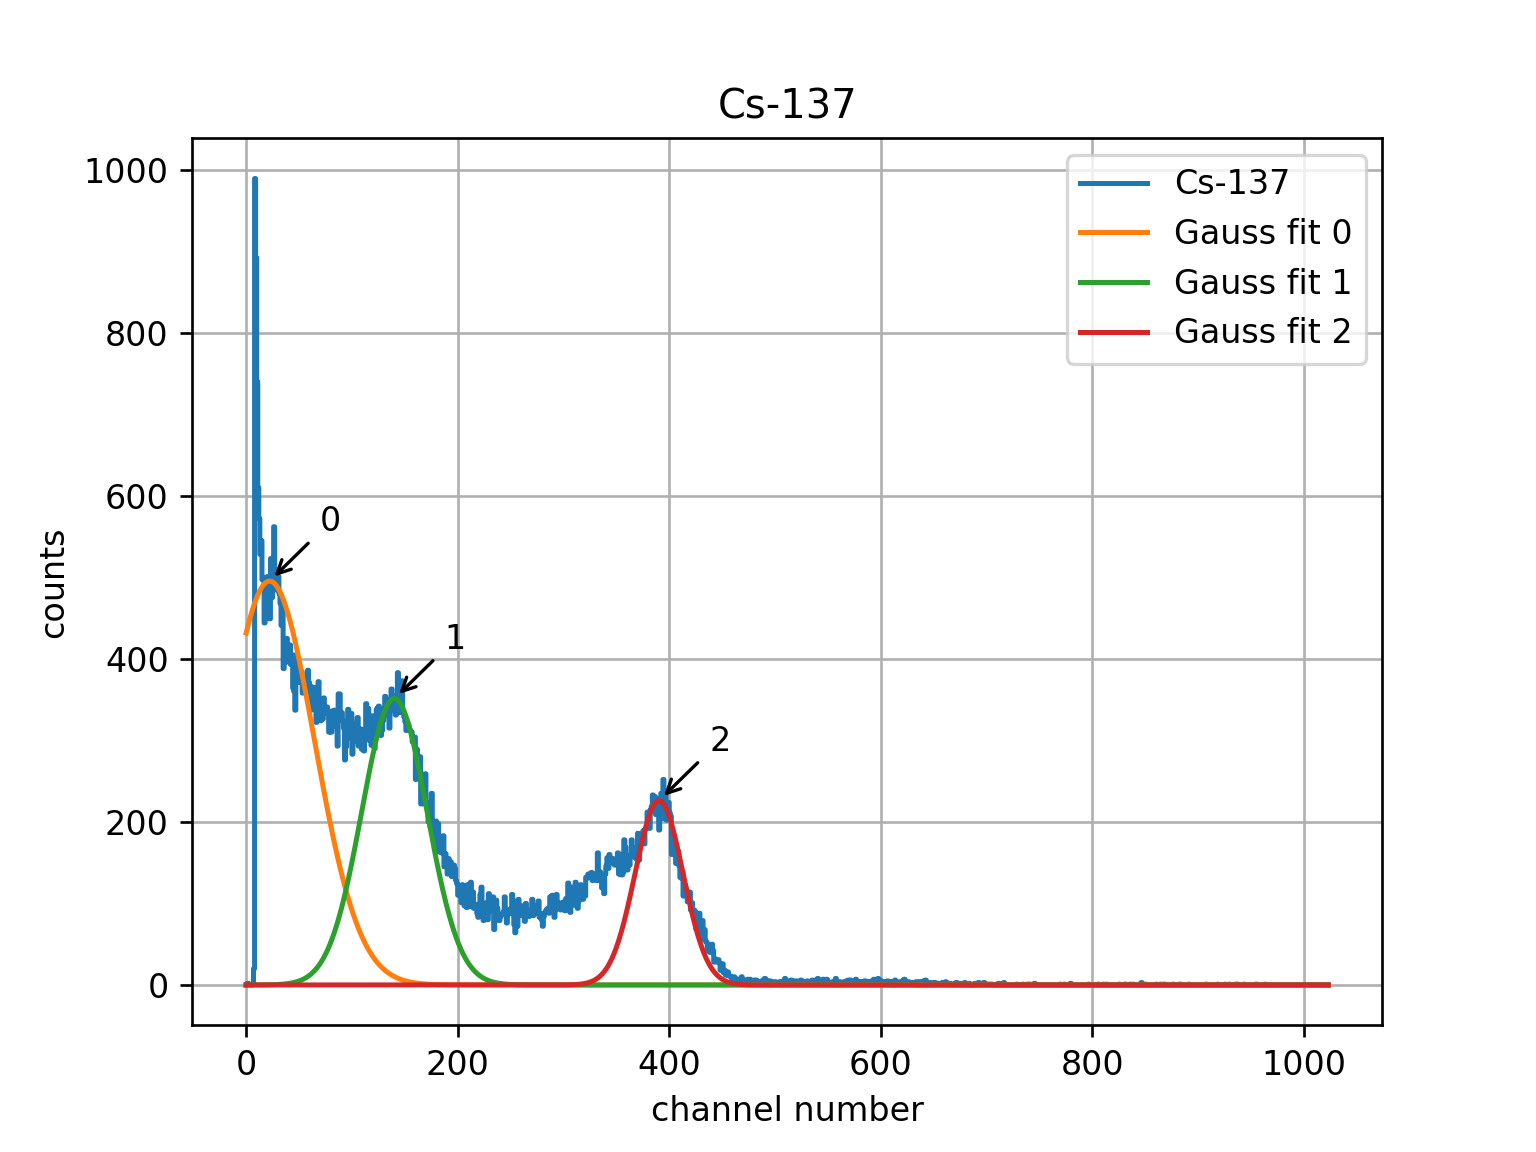

Fitted Gaussian #0: A: 495.3016, mu: 22.2218, sigma: 42.3465
Fitted Gaussian #1: A: 351.2297, mu: 140.1639, sigma: 30.8121
Fitted Gaussian #2: A: 226.1606, mu: 390.3968, sigma: 22.6323


In [14]:
## set up a new plot
fig, axes = plt.subplots() # makes new plot
plt.grid(True)
plt.xlabel('channel number')
plt.ylabel('counts')
plt.title("Cs-137")

## plot the cs-137 data
plt.plot(cs137.x, cs137.y, linestyle='steps',label="Cs-137")
## loop over all the fit results and enumerate them with an index
for idx, g in enumerate(gfits):
    ## print a line with the fit result
    print("Fitted Gaussian #{}: {}".format(idx, g.as_string()))
    ## plot this gaussian fit too
    plt.plot(cs137.x, g.value(cs137.x), 
             label="Gauss fit {}".format(idx))
    ## add a label to the peak position with the fit index
    plt.annotate(idx,
            xy=(g.mu, g.A), xycoords='data', # where to point to
            xytext=(15, 15), textcoords='offset points', # offset
            arrowprops=dict(arrowstyle="->")) # arrowstyle
    
plt.legend() # make legend visible
